In [40]:
import cv2
import numpy as np
import pandas as pd
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
from concurrent.futures import ProcessPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

In [41]:
labels_df = pd.read_csv('../label.csv')

image_directory = '../data'

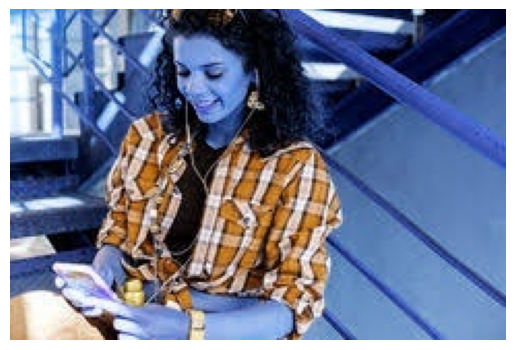

In [42]:
image_path = os.path.join(image_directory, "Image_1.jpg")
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off') 
plt.show()

In [43]:
# Function to extract ORB features
def extract_orb_features(image, max_features=128):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is not None:
        if descriptors.shape[0] > max_features:
            descriptors = descriptors[:max_features, :]
        elif descriptors.shape[0] < max_features:
            padding = np.zeros((max_features - descriptors.shape[0], descriptors.shape[1]))
            descriptors = np.vstack((descriptors, padding))
        return descriptors.flatten()
    else:
        return np.zeros(max_features * 32)

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray_image, pixels_per_cell=(24, 24), block_norm='L2-Hys')
    return features

# Function to extract LBP features
def extract_lbp_features(image, radii=[1, 2, 3], n_points=8, method='uniform'):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_features = []
    
    for radius in radii:
        lbp = local_binary_pattern(gray_image, n_points, radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.extend(hist)
    
    return np.array(lbp_features) 

# Function to extract color histogram features
def extract_color_histogram(image):
    # Load the image
    
    # Compute the histogram for each color channel (B, G, R)
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])
    
    # Normalize the histograms
    hist_b = cv2.normalize(hist_b, hist_b).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_r = cv2.normalize(hist_r, hist_r).flatten()

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([hist_b, hist_g, hist_r])

    # print(hist_features.shape)

    return hist_features

# Function to extract SIFT features
def extract_sift_features(image, max_features=128):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        if descriptors.shape[0] > max_features:
            descriptors = descriptors[:max_features, :]
        elif descriptors.shape[0] < max_features:
            padding = np.zeros((max_features - descriptors.shape[0], descriptors.shape[1]))
            descriptors = np.vstack((descriptors, padding))
        return descriptors.flatten()
    else:
        return np.zeros(max_features * 128)

# # Function to extract Good Features to Track (GFTT)
# def extract_gftt_features(image, max_features=128):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gftt = cv2.GFTTDetector_create(maxCorners=max_features, qualityLevel=0.01, minDistance=10)
#     keypoints = gftt.detect(gray_image, None)
#     keypoints = keypoints[:max_features] if len(keypoints) > max_features else keypoints
#     return np.array([kp.pt for kp in keypoints]).flatten()

# Function to extract Sobel edge features
# def extract_sobel_features(image):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
#     sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
#     sobel_combined = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
#     return sobel_combined.flatten()

# Combine all features into a single feature vector
def extract_combined_features(image):
    # Extract various features
    orb_features = extract_orb_features(image)
    hog_features = extract_hog_features(image)
    lbp_features = extract_lbp_features(image)
    color_histogram = extract_color_histogram(image)
    sift_features = extract_sift_features(image)
    # gftt_features = extract_gftt_features(image)
    # sobel_features = extract_sobel_features(image)
    
    # Create a dictionary with feature names and their lengths
    feature_lengths = {
        "ORB Features": orb_features.shape[0] if orb_features is not None else 0,
        "HOG Features": hog_features.shape[0] if hog_features is not None else 0,
        "LBP Features": lbp_features.shape[0] if lbp_features is not None else 0,
        "Color Histogram": color_histogram.shape[0] if color_histogram is not None else 0,
        "SIFT Features": sift_features.shape[0] if sift_features is not None else 0,
        # "GFTT Features": gftt_features.shape[0] if gftt_features is not None else 0,
        # "Sobel Features": sobel_features.shape[0] if sobel_features is not None else 0,
    }

    # Print all feature lengths in one statement
    print(", ".join([f"{name}: {length}" for name, length in feature_lengths.items()]))

    
    # Combine all features into a single array
    combined_features = np.concatenate((
        orb_features, 
        hog_features, 
        lbp_features, 
        color_histogram, 
        sift_features, 
        # gftt_features, 
        # sobel_features
    ))
    return combined_features


In [44]:
X = labels_df['filename']
y = labels_df['label']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [46]:
def process_image(image_name, label):
    # print(image_name, label)
    image_path = os.path.join(image_directory, image_name)
    image = cv2.imread(image_path)

    if image is None:
        return None

    # Resize image
    resized_image = cv2.resize(image, (250, 200))

    # Extract combined features
    combined_features = extract_combined_features(resized_image)
    # print(len(combined_features))

    # Return the features with the label
    return np.append(combined_features, label)


In [47]:
def extract_features(image_names, labels):
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_image, image_names, labels))

    # Filter out None results (in case any image failed to load)
    results = [result for result in results if result is not None]
    
    return np.array(results)


In [48]:
print(X_train.head())

12359    Image_12360.jpg
9243      Image_9244.jpg
11838    Image_11839.jpg
3524      Image_3525.jpg
3475      Image_3476.jpg
Name: filename, dtype: object


In [49]:
print(y_train.head())

12359     cycling
9243     drinking
11838    clapping
3524      texting
3475      cycling
Name: label, dtype: object


In [ ]:
train_features = extract_features(X_train, y_train)
test_features = extract_features(X_test, y_test)

# Separate features and labels
X_train_features = train_features[:, :-1]
y_train_labels = train_features[:, -1]

X_test_features = test_features[:, :-1]
y_test_labels = test_features[:, -1]





[ WARN:0@2092.566] global loadsave.cpp:241 findDecoder imread_('../data/Image_9751.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.566] global loadsave.cpp:241 findDecoder imread_('../data/Image_9244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.586] global loadsave.cpp:241 findDecoder imread_('../data/Image_8920.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.566] global loadsave.cpp:241 findDecoder imread_('../data/Image_7832.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.587] global loadsave.cpp:241 findDecoder imread_('../data/Image_9319.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.586] global loadsave.cpp:241 findDecoder imread_('../data/Image_9641.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.566] global loadsave.cpp:241 findDecoder imread_('../data/Image_8218.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2092.566] global loadsave

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(train_features.shape)
print(test_features.shape)


In [13]:
# Apply PCA only on the training data to avoid data leakage
pca = PCA(n_components=250)  # Adjust the number of components as needed

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Load the preprocessed features and labels from CSV
# train_df = pd.read_csv('train_features.csv', header=None)

# Separate features and labels
# X_train = train_df.iloc[:, 1:].values  # Features
# y_train = train_df.iloc[:, 0].values  # Labels (assuming label is in the first column)

# # Load the preprocessed features and labels from CSV
# test_df = pd.read_csv('test_features.csv', header=None)

# # Separate features and labels
# X_test = test_df.iloc[:, 1:].values  # Features
# y_test = test_df.iloc[:, 0].values  # Labels (assuming label is in the first column)

# Split the loaded data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use LazyClassifier for a quick comparison of models
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_pca, X_test_pca, y_train, y_test)

# Print out the model performance
print(models)

In [ ]:
best_rf_params = {
    "n_estimators": 5000,
    "min_samples_split": 10,
    "max_features":'sqrt',
    "max_depth":30,
    "random_state": 42,
    "n_jobs": -1

}

rf = RandomForestClassifier(**best_rf_params)
rf.fit(X_train_scaled, y_train_labels)

# Test the model
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

In [17]:
model_filename = 'trained_random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(rf, file)